# КУРСОВОЙ ПРОЕКТ

#### Задача:
Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

#### Наименование файлов с данными:
* course_project_train.csv - обучающий датасет
* course_project_test.csv - тестовый датасет

#### Целевая переменная:
Credit Default - факт невыполнения кредитных обязательств

#### Метрика качества:
* F1-score (sklearn.metrics.f1_score)

#### Требования к решению:
* Целевая метрика F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

#### Описание датасета:

* Home Ownership - домовладение
* Annual Income - годовой доход
* Years in current job - количество лет на текущем месте работы
* Tax Liens - налоговые обременения
* Number of Open Accounts - количество открытых счетов
* Years of Credit History - количество лет кредитной истории
* Maximum Open Credit - наибольший открытый кредит
* Number of Credit Problems - количество проблем с кредитом
* Months since last delinquent - количество месяцев с последней просрочки платежа
* Bankruptcies - банкротства
* Purpose - цель кредита
* Term - срок кредита
* Current Loan Amount - текущая сумма кредита
* Current Credit Balance - текущий кредитный баланс
* Monthly Debt - ежемесячный долг
* Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Импорт библиотек

In [207]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import probplot

In [208]:
import warnings
warnings.simplefilter('ignore')

### Загрузка и обзор данных

In [3]:
TRAIN_DATASET_PATH = r'C:\Users\janny\Desktop\GeekBrains\ОСНОВНОЕ ОБУЧЕНИЕ\КУРСОВАЯ (2 четверть)\course_project_train.csv'
TEST_DATASET_PATH = r'C:\Users\janny\Desktop\GeekBrains\ОСНОВНОЕ ОБУЧЕНИЕ\КУРСОВАЯ (2 четверть)\course_project_test.csv'

In [4]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [5]:
df_train['ID'] = df_train.index.tolist()

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [7]:
df_train.shape

(7500, 18)

In [8]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.00,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.00,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.00,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.50,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.50,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.00,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.00,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.00,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.00,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.50,209323.0,360406.25,6.506797e+06


In [9]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [11]:
df_test.shape

(2500, 16)

### Обработка пропусков

In [12]:
len(df_train) - df_train.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
ID                                 0
dtype: int64

In [13]:
len(df_test) - df_test.count()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

### Работа с функциями

In [14]:
def corr_(val, x1, x2):
    pay1_and_target_s = df_train.loc[df_train[val].isin([x1, x2]), ['ID', val, 'Credit Default']]
    table = pay1_and_target_s.pivot_table(values='ID', index=val, columns='Credit Default', aggfunc='count')
    chi2, p, dof, expected = chi2_contingency(table, correction=False)
    print(p)

In [15]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [16]:
def mis_values_report(df_train):
    mis_val = df_train.isnull().sum()
    perc_mis_val = 100 * df_train.isnull().sum() / len(df_train)
    report = pd.concat([mis_val, perc_mis_val], axis=1)
    report_columns = report.rename(columns = {0: 'Пропущенные значения', 1: '% от всех значений'})
    report_columns = report_columns[report_columns.iloc[:,1] != 0].sort_values('% от всех значений', ascending=False).round(1)
    print('Датафрейм имеет ' + str(df_train.shape[1]) + ' столбцов.\n' + str(report_columns.shape[0]) + ' столбцов имеют пропущенные значения')
    return report_columns

In [17]:
def hist_qq(target_name):
    plt.figure(figsize=(20,8))

    ax1 = plt.subplot(121)
    ax1.set_xlabel(target_name)
    ax1.set_ylabel('Count')
    ax1.set_title(f'{target_name} distribution')
    df_train[target_name].hist()
    plt.subplot(122)
    probplot(df_train[target_name],dist='norm',plot=plt)

    plt.show()

In [18]:
def balance_df_train_by_target(df_train, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df_train[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df_train[df_train[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df_train = df_train.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_train = df_train.copy()
        df_train = df_train[df_train[target_name] == minor_class_name]
        tmp = df_train[df_train[target_name] == major_class_name]
        df_train = df_train.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df_train.drop(columns=target_name), df_train[target_name])
        df_train = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_sample(df_train.drop(columns=target_name), df_train[target_name])
        df_train = pd.concat([X_smote, y_smote], axis=1)

    return df_train.sample(frac=1) 

In [19]:
mis_values_report(df_train)

Датафрейм имеет 18 столбцов.
5 столбцов имеют пропущенные значения


,Пропущенные значения,% от всех значений
Months since last delinquent,4081,54.4
Annual Income,1557,20.8
Credit Score,1557,20.8
Years in current job,371,4.9
Bankruptcies,14,0.2


### Обработка данных

In [20]:
df_train['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

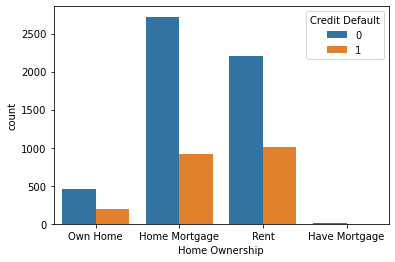

In [21]:
sns.countplot(x="Home Ownership", hue='Credit Default', data=df_train)
plt.show()

In [22]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['Home Ownership'], prefix='Home Ownership')], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['Home Ownership'], prefix='Home Ownership')], axis=1)

#### Annual Income (годовой доход)

In [23]:
df_train['Annual Income'].describe()

count    5.943000e+03
mean     1.366392e+06
std      8.453392e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      1.014934e+07
Name: Annual Income, dtype: float64

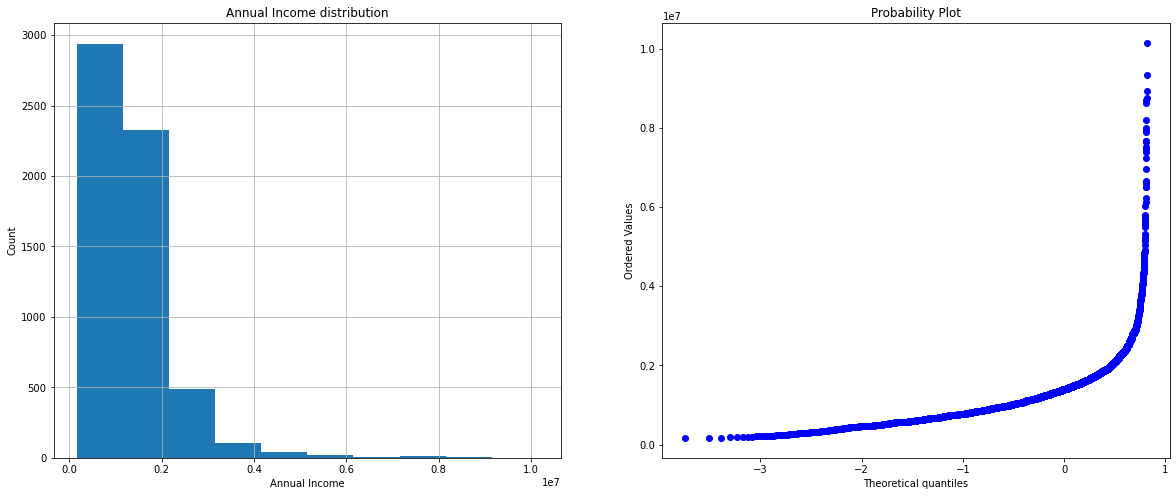

In [24]:
hist_qq('Annual Income')

In [25]:
df_train.loc[df_train['Annual Income'].isnull(), 'Annual Income'] = 0
df_test.loc[df_test['Annual Income'].isnull(), 'Annual Income'] = 0

Обработка попусков и выбросов при помощи линейной регрессии

In [26]:
df_train.loc[(df_train['Annual Income'] > df_train['Annual Income'].quantile(.95)), :].shape

(375, 22)

Корреляция признаков с годовым доходом

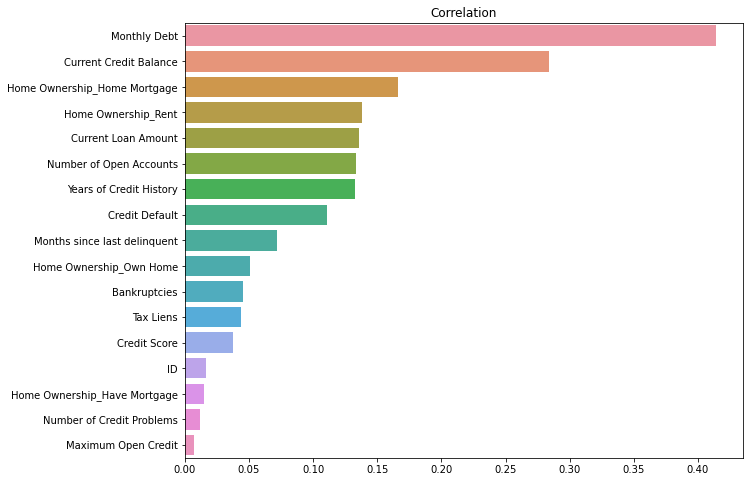

In [27]:
FEATURE_NAMES = df_train.columns.drop('Annual Income').tolist()
corr_Annual_Income = df_train[FEATURE_NAMES + ['Annual Income']].corr().iloc[:-1, -1]
corr_Annual_Income = np.abs(corr_Annual_Income).sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_Annual_Income.values, y=corr_Annual_Income.index)

plt.title('Correlation')
plt.show()

Выбор таргетных признаков и набора данных для дальнейшего обучения модели

In [28]:
TARGET_FEATURE = list(corr_Annual_Income.index[0:6])

In [29]:
data = df_train.loc[(df_train['Annual Income'].notnull()), TARGET_FEATURE + ['Annual Income']]
data

,Monthly Debt,Current Credit Balance,Home Ownership_Home Mortgage,Home Ownership_Rent,Current Loan Amount,Number of Open Accounts,Annual Income
0,7914.0,47386.0,0,0,99999999.0,11.0,482087.0
1,18373.0,394972.0,0,0,264968.0,15.0,1025487.0
2,13651.0,308389.0,1,0,99999999.0,11.0,751412.0
3,11338.0,95855.0,0,0,121396.0,8.0,805068.0
4,7180.0,93309.0,0,1,125840.0,13.0,776264.0
...,...,...,...,...,...,...,...
7495,1900.0,73492.0,0,1,129360.0,3.0,402192.0
7496,12783.0,456399.0,1,0,444048.0,10.0,1533984.0
7497,12479.0,477812.0,0,1,99999999.0,12.0,1878910.0
7498,37118.0,476064.0,1,0,615274.0,21.0,0.0


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7500 entries, 0 to 7499
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Monthly Debt                  7500 non-null   float64
 1   Current Credit Balance        7500 non-null   float64
 2   Home Ownership_Home Mortgage  7500 non-null   uint8  
 3   Home Ownership_Rent           7500 non-null   uint8  
 4   Current Loan Amount           7500 non-null   float64
 5   Number of Open Accounts       7500 non-null   float64
 6   Annual Income                 7500 non-null   float64
dtypes: float64(5), uint8(2)
memory usage: 366.2 KB


In [31]:
%%time
model_Annual_Income = LogisticRegression()
model_Annual_Income.fit(data[TARGET_FEATURE], data['Annual Income'])

Wall time: 3min 53s


LogisticRegression()

In [38]:
shapiro(df_train['Annual Income'])

ShapiroResult(statistic=0.8498488068580627, pvalue=0.0)

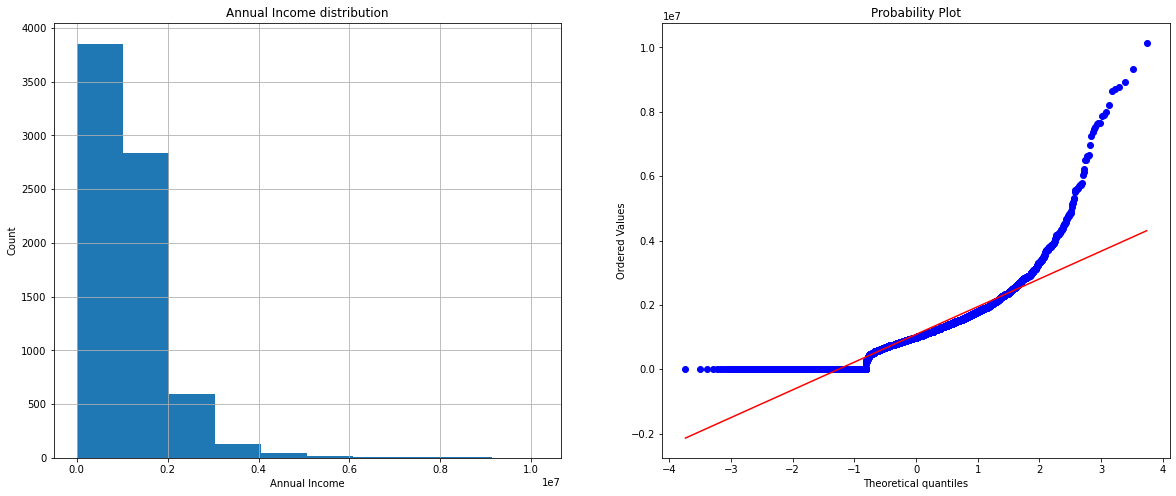

In [39]:
hist_qq('Annual Income')

In [40]:
Annual_Income_with_target_s = df_train[['Annual Income', 'Credit Default']]
Annual_Income_target_0 = df_train.loc[df_train['Credit Default'] == 0, ['Annual Income']]
Annual_Income_target_1 = df_train.loc[df_train['Credit Default'] == 1, ['Annual Income']]

In [41]:
mannwhitneyu(Annual_Income_target_0, Annual_Income_target_1)

MannwhitneyuResult(statistic=4845758.5, pvalue=3.7504710422369535e-24)

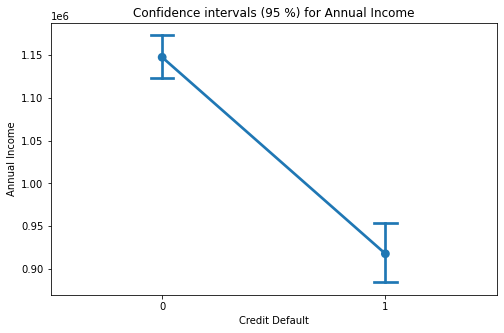

In [42]:
plt.figure(figsize=(8,5))

sns.pointplot(x='Credit Default', y='Annual Income', data=Annual_Income_with_target_s, capsize=.1)
plt.title('Confidence intervals (95 %) for Annual Income')

plt.show()

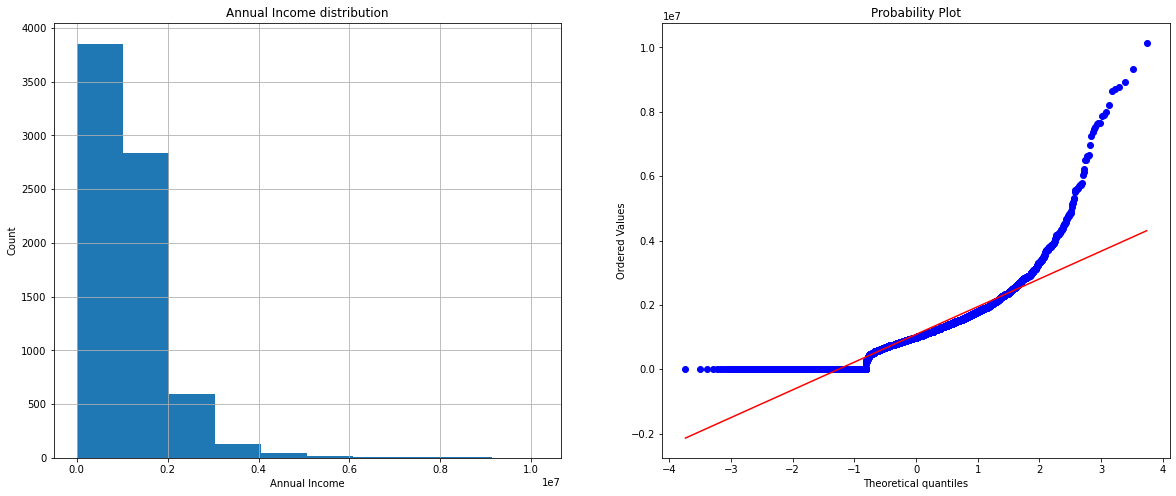

In [43]:
hist_qq('Annual Income')

In [44]:
df_train.loc[df_train['Annual Income'] > df_train['Annual Income'].quantile(.99), ['Annual Income']] =\
            df_train['Annual Income'].quantile(.99)  

df_test.loc[df_test['Annual Income'] > df_test['Annual Income'].quantile(.99), ['Annual Income']] = \
            df_test['Annual Income'].quantile(.99)

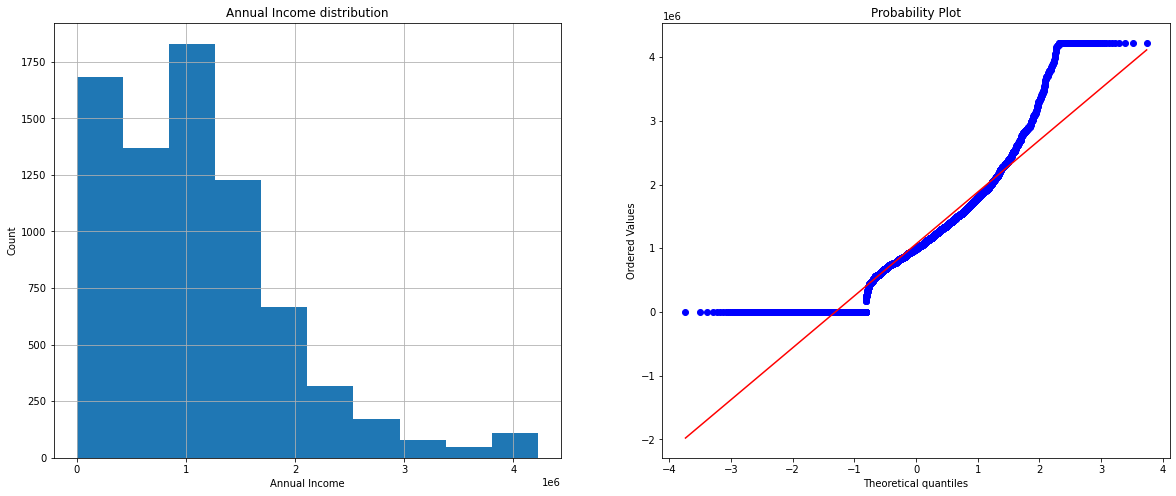

In [45]:
hist_qq('Annual Income')

#### Years in current job (количество лет на текущем месте работы) 

In [46]:
df_train['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

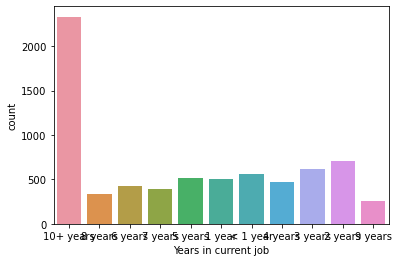

In [47]:
sns.countplot(x="Years in current job", data=df_train)
plt.show()

<AxesSubplot:xlabel='Years in current job', ylabel='count'>

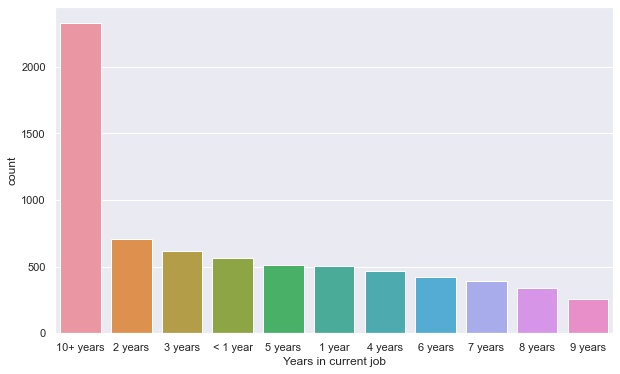

In [48]:
sns.set(style='darkgrid')
plt.figure(figsize=(10,6))
sns.countplot(df_train['Years in current job'], order = df_train['Years in current job'].value_counts().index)

In [49]:
df_train['Years in current job'] = df_train['Years in current job'].map({
                                                            '10+ years':'10', 
                                                            '9 years':'9',
                                                            '8 years':'8',
                                                            '7 years':'7',
                                                            '6 years':'6',
                                                            '5 years':'5',
                                                            '4 years':'4',
                                                            '3 years':'3',
                                                            '2 years':'2',
                                                            '1 year':'1',
                                                            '< 1 year':'0'
                                                            }).astype(float)

df_train.loc[df_train['Years in current job'].isnull(), 'Years in current job'] = 11



df_test['Years in current job'] = df_test['Years in current job'].map({
                                                            '10+ years':'10', 
                                                            '9 years':'9',
                                                            '8 years':'8',
                                                            '7 years':'7',
                                                            '6 years':'6',
                                                            '5 years':'5',
                                                            '4 years':'4',
                                                            '3 years':'3',
                                                            '2 years':'2',
                                                            '1 year':'1',
                                                            '< 1 year':'0'
                                                            }).astype(float)

df_test.loc[df_test['Years in current job'].isnull(), 'Years in current job'] = 11

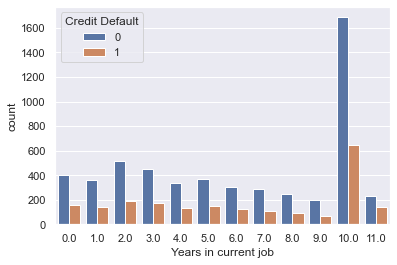

In [50]:
sns.countplot(x="Years in current job", hue='Credit Default', data=df_train)
plt.show()

<AxesSubplot:xlabel='Years in current job', ylabel='Credit Default'>

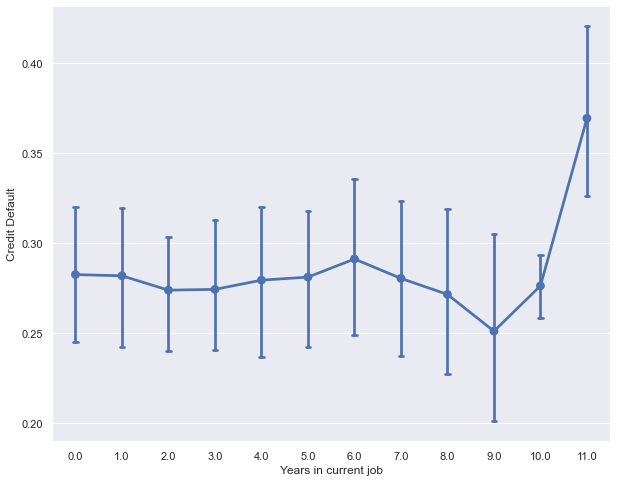

In [51]:
plt.figure(figsize=(10, 8))
sns.pointplot(x='Years in current job', y='Credit Default', data=df_train, capsize=.1,)

#### Tax Liens (налоговые обременения)

In [52]:
df_train['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64

#### Number of Open Accounts (количество открытых счетов)  

In [53]:
df_train['Number of Open Accounts'].describe()

count    7500.000000
mean       11.130933
std         4.908924
min         2.000000
25%         8.000000
50%        10.000000
75%        14.000000
max        43.000000
Name: Number of Open Accounts, dtype: float64

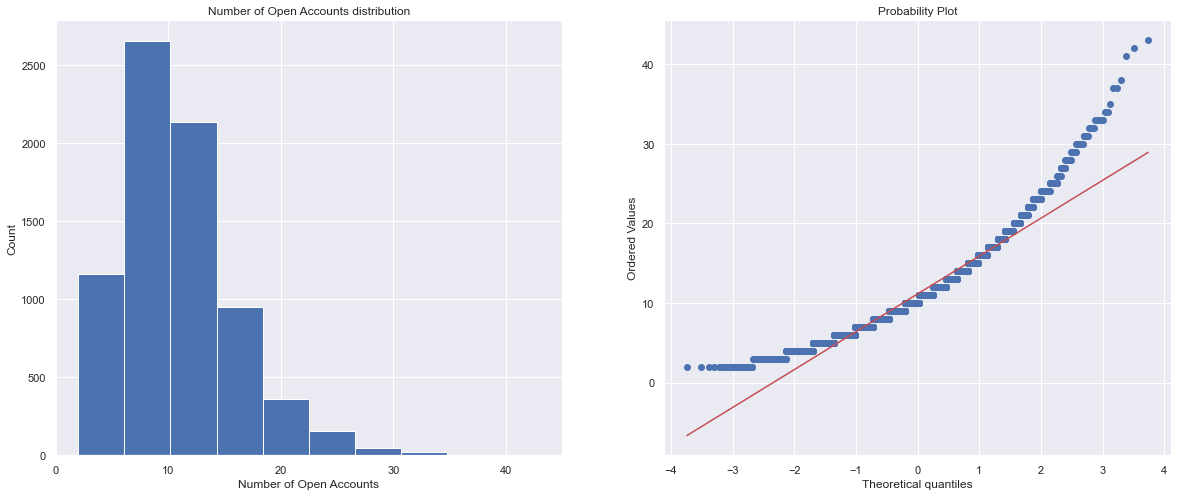

In [54]:
hist_qq('Number of Open Accounts')

In [56]:
df_train.loc[(df_train['Number of Open Accounts'] > df_train['Number of Open Accounts'].quantile(.95)), :].shape

(356, 22)

In [57]:
df_train.loc[df_train['Number of Open Accounts'] > df_train['Number of Open Accounts'].quantile(.95), ['Number of Open Accounts']] =\
            df_train['Number of Open Accounts'].median()

df_test.loc[df_test['Number of Open Accounts'] > df_test['Number of Open Accounts'].quantile(.95),  \
            ['Number of Open Accounts']] = df_test['Number of Open Accounts'].median()

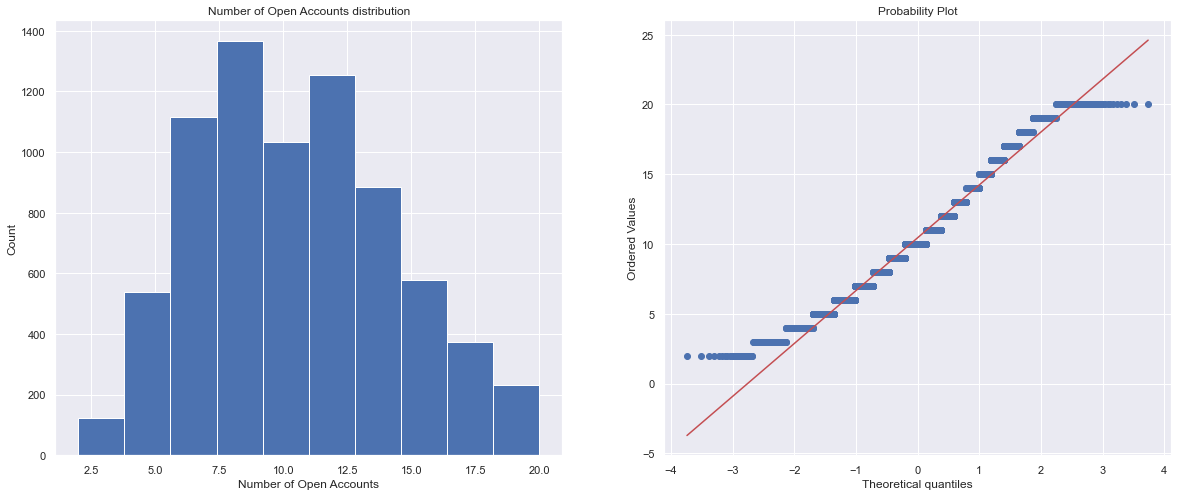

In [58]:
hist_qq('Number of Open Accounts')

#### Years of Credit History (коичество лет кредитной истории) 

In [59]:
df_train['Years of Credit History'].value_counts()

15.0    104
16.0     99
16.5     91
17.0     86
17.5     83
       ... 
43.5      1
50.0      1
40.1      1
51.5      1
41.6      1
Name: Years of Credit History, Length: 408, dtype: int64

<AxesSubplot:>

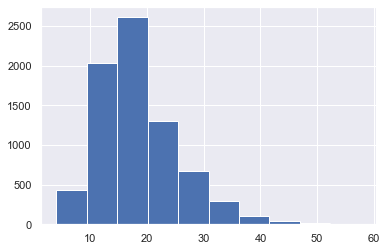

In [60]:
df_train['Years of Credit History'].hist()

In [61]:
df_train.loc[df_train['Years of Credit History'] > 40, ['Years of Credit History']] = 40 
df_test.loc[df_test['Years of Credit History'] > 40, ['Years of Credit History']] = 40

# 40 лет кредитной истории - слишком много, в связи с этим все значения выше 40 заменены на 40

<AxesSubplot:>

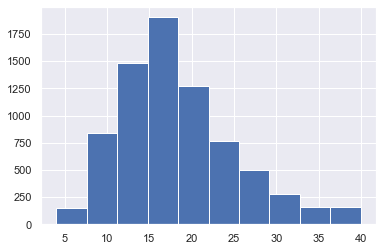

In [62]:
df_train['Years of Credit History'].hist()

#### Maximum Open Credit (наибольший открытый кредит) 

In [63]:
df_train['Maximum Open Credit'].describe()

count    7.500000e+03
mean     9.451537e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64

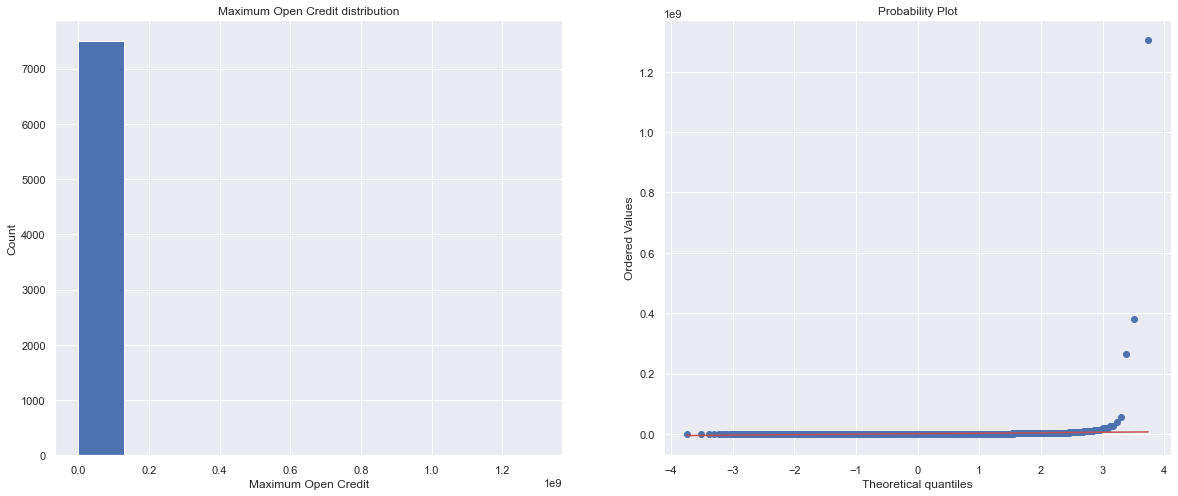

In [64]:
hist_qq('Maximum Open Credit')

In [65]:
df_train.loc[df_train['Maximum Open Credit'] > df_train['Maximum Open Credit'].quantile(.95), ['Maximum Open Credit']] =\
            df_train['Maximum Open Credit'].quantile(.95)

df_test.loc[df_test['Maximum Open Credit'] > df_test['Maximum Open Credit'].quantile(.95), ['Maximum Open Credit']] =\
            df_test['Maximum Open Credit'].quantile(.95)

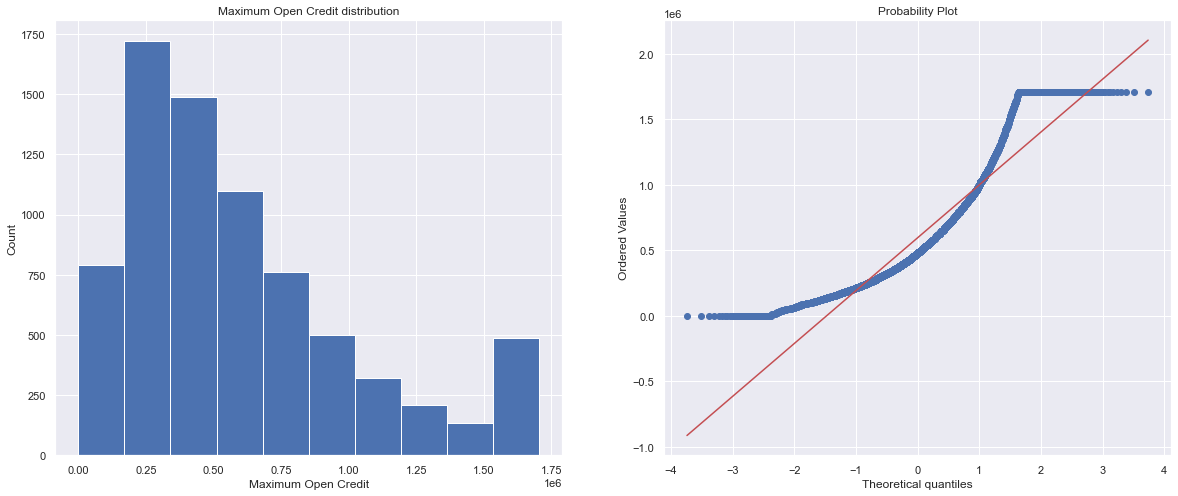

In [66]:
hist_qq('Maximum Open Credit')

#### Number of Credit Problems (количество проблем с кредитом)  

In [67]:
df_train['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

#### Bankruptcies (банкротства)

In [68]:
df_train['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [69]:
df_train.loc[df_train['Bankruptcies'].isnull(), 'Bankruptcies'] = 0
df_test.loc[df_test['Bankruptcies'].isnull(), 'Bankruptcies'] = 0

#### Months since last delinquent (количество месяцев с последней просрочки кредита)

In [70]:
df_train['Months since last delinquent'].describe()

count    3419.000000
mean       34.692600
std        21.688806
min         0.000000
25%        16.000000
50%        32.000000
75%        50.000000
max       118.000000
Name: Months since last delinquent, dtype: float64

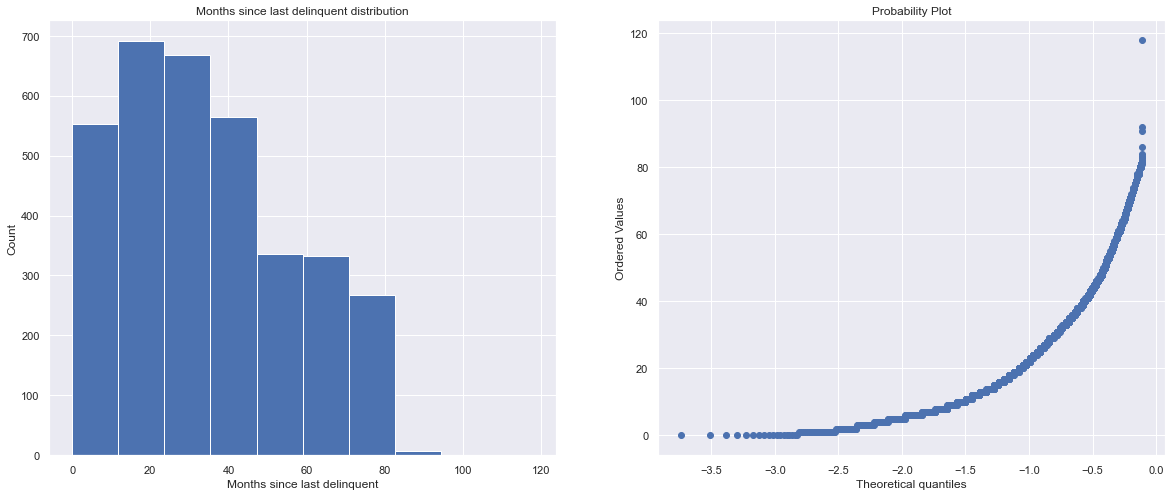

In [71]:
hist_qq('Months since last delinquent')

In [72]:
df_train['Months since last delinquent NULL'] = df_train['Months since last delinquent'].isnull()
df_train.loc[df_train['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 0
df_train['Months since last delinquent'].fillna(0, inplace=True)

df_test['Months since last delinquent NULL'] = df_test['Months since last delinquent'].isnull()
df_test.loc[df_test['Months since last delinquent'].isnull(), 'Months since last delinquent'] = 0

#### Purpose (цель кредита)

In [73]:
df_train['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [74]:
df_test['Purpose'].value_counts()

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
vacation                   3
educational expenses       3
wedding                    2
moving                     1
Name: Purpose, dtype: int64

<AxesSubplot:title={'center':'Purpose'}>

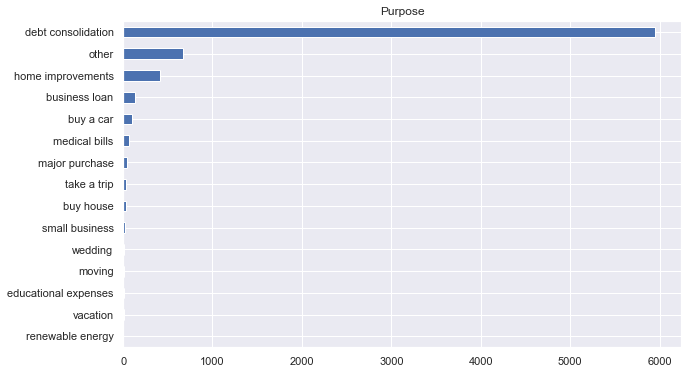

In [75]:
df_train['Purpose'].value_counts().sort_values(ascending=True).plot(kind='barh', title='Purpose', figsize=(10,6))

<AxesSubplot:title={'center':'Purpose / Credit Default'}, xlabel='Purpose'>

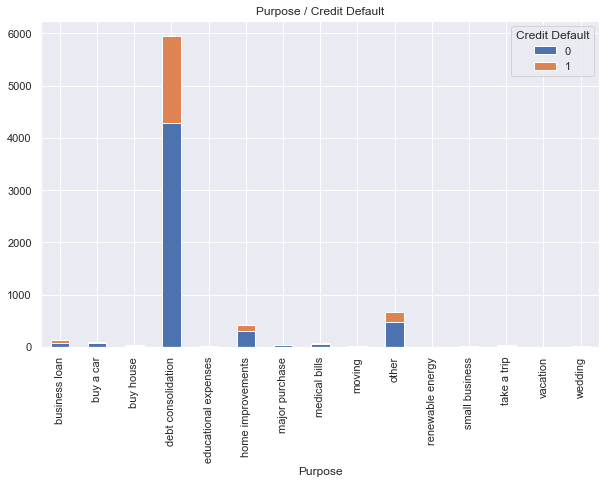

In [76]:
purpose_cr_deafult = df_train[['Purpose','Credit Default']]
pd.crosstab(purpose_cr_deafult['Purpose'], purpose_cr_deafult['Credit Default']).plot \
(kind='bar', stacked=True, figsize=(10,6), title="Purpose / Credit Default", )

<AxesSubplot:xlabel='Purpose', ylabel='Credit Default'>

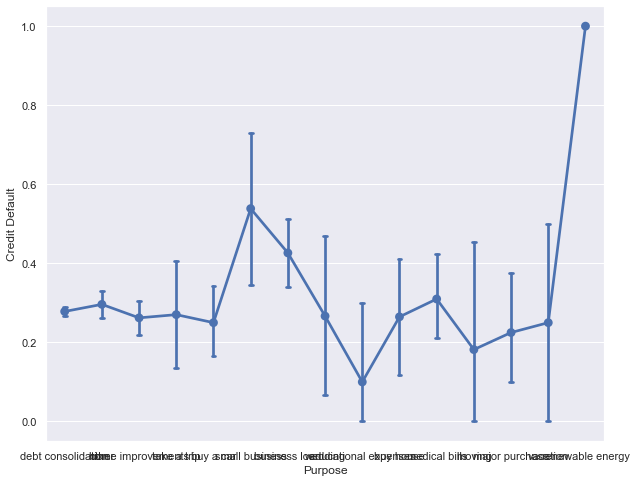

In [77]:
plt.figure(figsize=(10, 8))
sns.pointplot(x='Purpose', y='Credit Default', data=df_train, capsize=.1,)

In [79]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['Purpose'], prefix='Purpose')], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['Purpose'], prefix='Purpose')], axis=1)

In [80]:
df_train['Purpose'] = df_train['Purpose'].map({
                                'debt consolidation':'0', 
                                'other':'0',
                                'home improvements':'0',
                                'business loan':'1',
                                'buy a car':'0',
                                'medical bills':'0',
                                'major purchase':'0',
                                'take a trip':'0',
                                'buy house':'0',
                                'small business':'2',
                                'wedding':'0',
                                'moving':'0',
                                'educational expenses':'3',
                                'vacation':'0',
                                'renewable energy':'0'
                                }).astype(float)

In [82]:
df_test['Purpose'] = df_test['Purpose'].map({
                                'debt consolidation':'0', 
                                'other':'0',
                                'home improvements':'0',
                                'business loan':'1',
                                'buy a car':'0',
                                'medical bills':'0',
                                'major purchase':'0',
                                'take a trip':'0',
                                'buy house':'0',
                                'small business':'2',
                                'wedding':'0',
                                'moving':'0',
                                'educational expenses':'3',
                                'vacation':'0',
                                'renewable energy':'0'
                                }).astype(float)

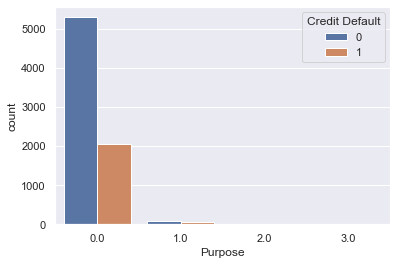

In [84]:
sns.countplot(x="Purpose", hue='Credit Default', data=df_train)
plt.show()

#### Term (срок кредита)

In [85]:
df_train['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

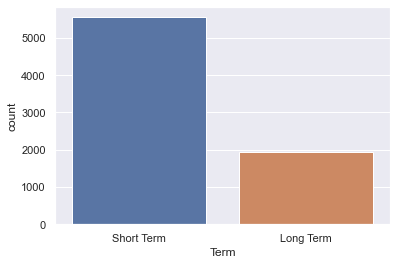

In [86]:
sns.countplot(x="Term", data=df_train)
plt.show()

In [87]:
df_train['Term'] = df_train['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(float)
df_test['Term'] = df_test['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(float)

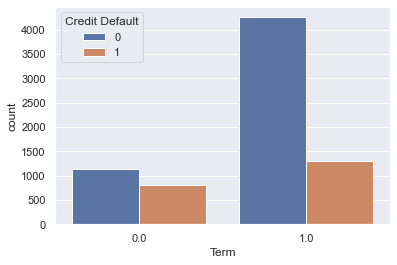

In [89]:
sns.countplot(x="Term", hue='Credit Default', data=df_train)
plt.show()

In [90]:
corr_('Term',0,1)

1.1519373940439208e-55


#### Current Loan Amount (текущая сумма кредита)

In [92]:
df_train['Current Loan Amount'].value_counts()

99999999.0    870
218064.0        6
89298.0         6
216106.0        5
265826.0        5
             ... 
104324.0        1
201080.0        1
427812.0        1
665544.0        1
191136.0        1
Name: Current Loan Amount, Length: 5386, dtype: int64

In [93]:
df_train['Current Loan Amount'].describe()

count    7.500000e+03
mean     1.187318e+07
std      3.192612e+07
min      1.124200e+04
25%      1.801690e+05
50%      3.095730e+05
75%      5.198820e+05
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

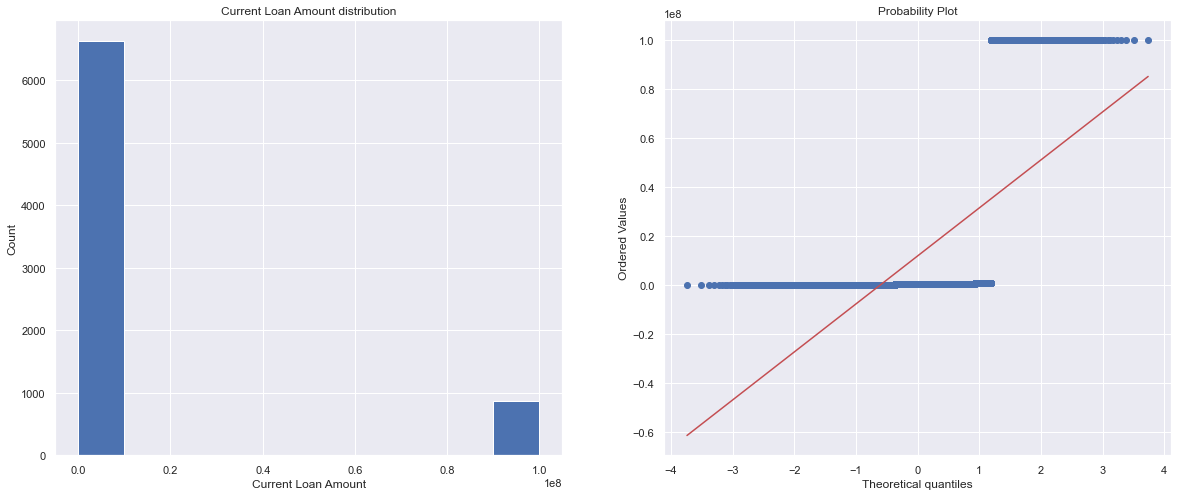

In [94]:
hist_qq('Current Loan Amount')

In [95]:
df_train['Current Loan Amount BIG'] = df_train['Current Loan Amount'] == 99999999
df_test['Current Loan Amount BIG'] = df_test['Current Loan Amount'] == 99999999

# вынесение в отдельную переменную значительных выбросов 

In [96]:
df_train.loc[df_train['Current Loan Amount'] == 99999999, ['Current Loan Amount']] = None
df_test.loc[df_test['Current Loan Amount'] == 99999999, ['Current Loan Amount']] = None

In [97]:
df_train.loc[df_train['Current Loan Amount'].isnull(), 'Current Loan Amount'] = df_train['Current Loan Amount'].mean() 
df_test.loc[df_test['Current Loan Amount'].isnull(), 'Current Loan Amount'] = df_test['Current Loan Amount'].mean()

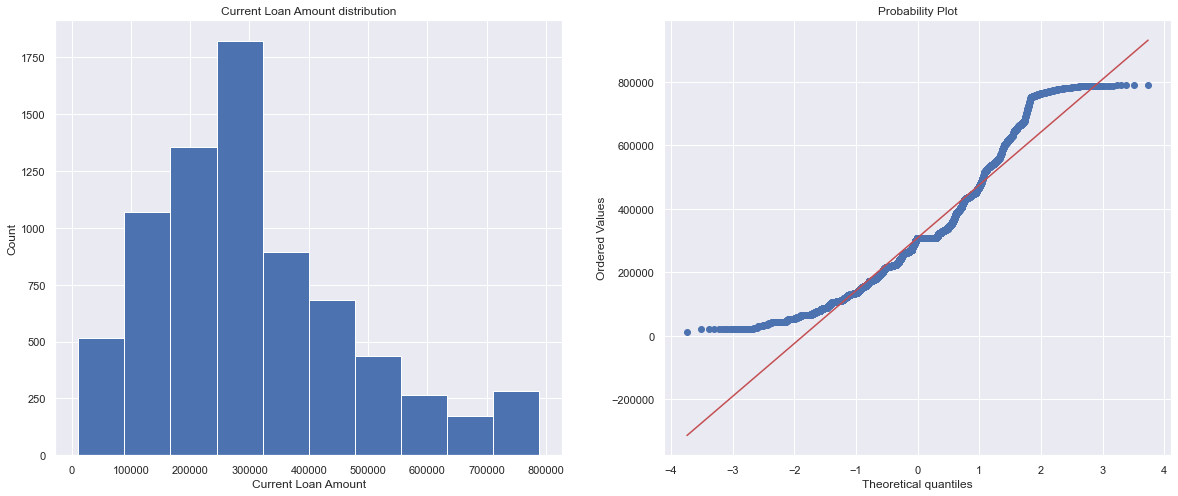

In [98]:
hist_qq('Current Loan Amount')

#### Current Credit Balance (текущий кредитный баланс)

In [99]:
df_train['Current Credit Balance'].describe()

count    7.500000e+03
mean     2.898332e+05
std      3.178714e+05
min      0.000000e+00
25%      1.142565e+05
50%      2.093230e+05
75%      3.604062e+05
max      6.506797e+06
Name: Current Credit Balance, dtype: float64

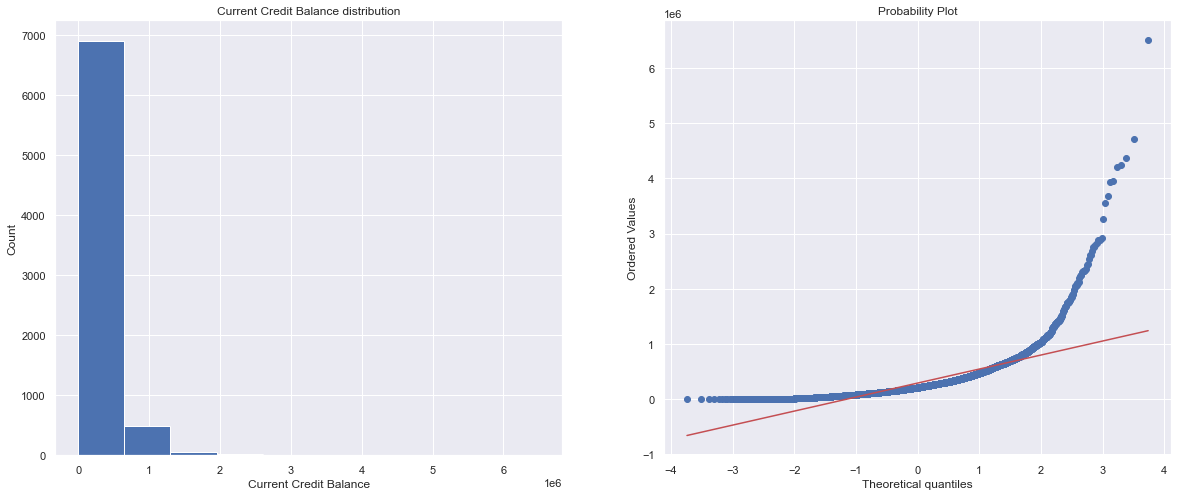

In [100]:
hist_qq('Current Credit Balance')

In [101]:
df_train.loc[df_train['Current Credit Balance'] > df_train['Current Credit Balance'].quantile(.95), :].shape

(375, 39)

In [103]:
df_train.loc[df_train['Current Credit Balance'] > df_train['Current Credit Balance'].quantile(.95), \
       ['Current Credit Balance']] = df_train['Current Credit Balance'].quantile(.95) 

df_test.loc[df_test['Current Credit Balance'] > df_test['Current Credit Balance'].quantile(.95), \
       ['Current Credit Balance']] = df_test['Current Credit Balance'].quantile(.95) 

#### Monthly Debt (ежемесячный долг)

In [105]:
df_train['Monthly Debt'].value_counts()

0.0        6
19667.0    4
19222.0    4
19277.0    3
9669.0     3
          ..
12857.0    1
10777.0    1
29267.0    1
25050.0    1
31119.0    1
Name: Monthly Debt, Length: 6716, dtype: int64

<AxesSubplot:>

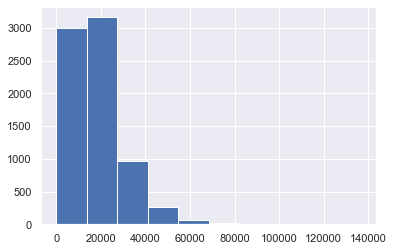

In [107]:
df_train['Monthly Debt'].hist()

<AxesSubplot:>

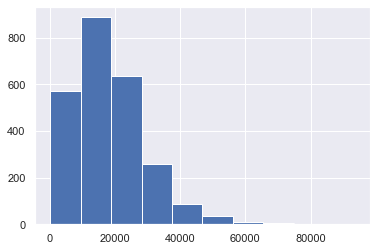

In [108]:
df_test['Monthly Debt'].hist()

In [109]:
df_train.loc[df_train['Monthly Debt'] > df_train['Monthly Debt'].quantile(.99), \
       ['Monthly Debt']] = df_train['Monthly Debt'].mean()

df_test.loc[df_test['Monthly Debt'] > df_test['Monthly Debt'].quantile(.99), \
       ['Monthly Debt']] = df_test['Monthly Debt'].mean()

<AxesSubplot:>

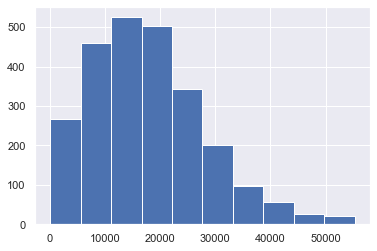

In [110]:
df_test['Monthly Debt'].hist()

#### Credit Score (кредитный рейтинг)

In [111]:
df_train['Credit Score'].describe()

count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

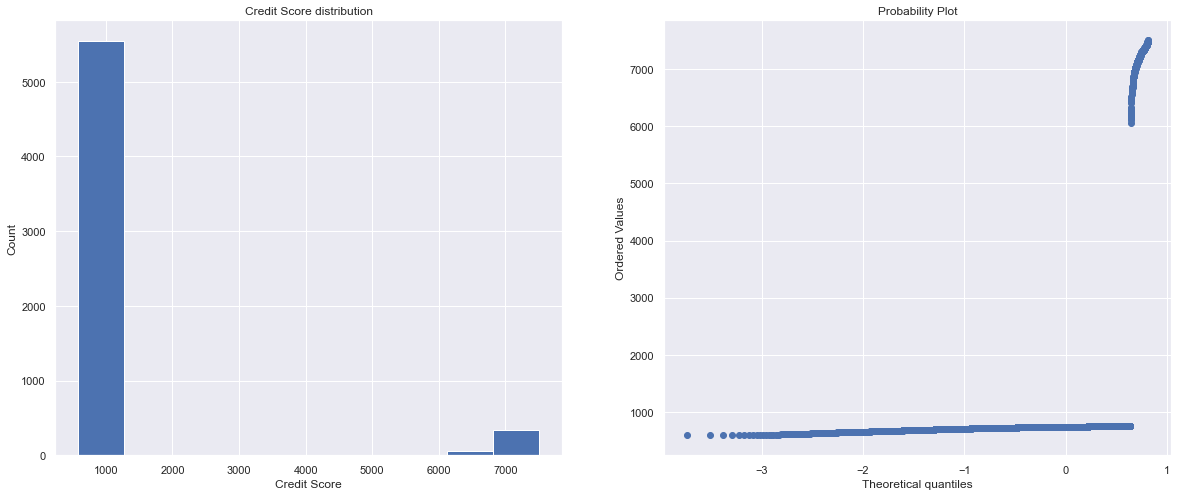

In [112]:
hist_qq('Credit Score')

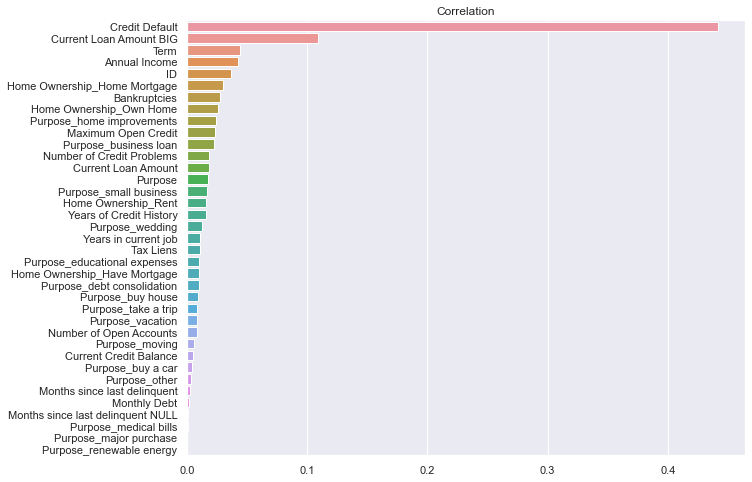

In [113]:
FEATURE_NAMES = df_train.columns.drop('Credit Score').tolist()
corr_Credit_Score = df_train[FEATURE_NAMES + ['Credit Score']].corr().iloc[:-1, -1]
corr_Credit_Score = np.abs(corr_Credit_Score).sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_Credit_Score.values, y=corr_Credit_Score.index)

plt.title('Correlation')
plt.show()

### Обучение модели

In [115]:
TARGET_FEATURE = list(corr_Credit_Score.index[0:15])

TARGET_FEATURE = [
                 'Credit Default',
                 'Current Loan Amount BIG',
                 'Current Loan Amount',
                 'Term',
                 'Annual Income',
                 'ID',
                 'Home Ownership_Home Mortgage',
                 'Bankruptcies',
                 'Home Ownership_Own Home',
                 'Maximum Open Credit',
                 'Number of Credit Problems',
                 'Purpose',
                 'Home Ownership_Rent',
                 'Years of Credit History',
                 'Years in current job'
                 ]

# выбор наиболее влияющих на обучение признаков

In [116]:
data = df_train.loc[(df_train['Credit Score'].notnull()), TARGET_FEATURE + ['Credit Score']]

# выбор набора обучающих данных

In [117]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5943 entries, 0 to 7497
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Credit Default                5943 non-null   int64  
 1   Current Loan Amount BIG       5943 non-null   bool   
 2   Current Loan Amount           5943 non-null   float64
 3   Term                          5943 non-null   float64
 4   Annual Income                 5943 non-null   float64
 5   ID                            5943 non-null   int64  
 6   Home Ownership_Home Mortgage  5943 non-null   uint8  
 7   Bankruptcies                  5943 non-null   float64
 8   Home Ownership_Own Home       5943 non-null   uint8  
 9   Maximum Open Credit           5943 non-null   float64
 10  Number of Credit Problems     5943 non-null   float64
 11  Purpose                       5943 non-null   float64
 12  Home Ownership_Rent           5943 non-null   uint8  
 13  Yea

In [119]:
%%time
model_Credit_Score = LogisticRegression()
model_Credit_Score.fit(data[TARGET_FEATURE], data['Credit Score'])

Wall time: 7.17 s


LogisticRegression()

In [121]:
shapiro(df_train['Credit Score'])

ShapiroResult(statistic=0.26511114835739136, pvalue=0.0)

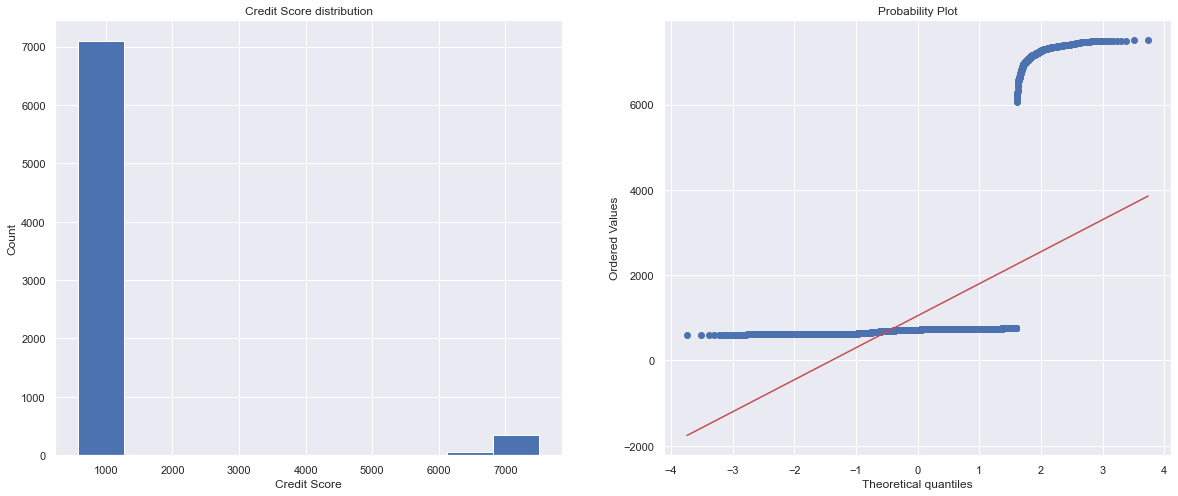

In [122]:
hist_qq('Credit Score')

In [131]:
df_train.loc[(df_train['Credit Score'] < 700), 'Credit Score'] = 0
df_train.loc[(df_train['Credit Score'] >= 700) & (df_train['Credit Score'] < 740), 'Credit Score'] = 1
df_train.loc[(df_train['Credit Score'] >= 740) & (df_train['Credit Score'] <= 750), 'Credit Score'] = 2
df_train.loc[(df_train['Credit Score'] >= 750) & (df_train['Credit Score'] <= 800), 'Credit Score'] = 3
df_train.loc[(df_train['Credit Score'] > 800), 'Credit Score'] = 4

df_test.loc[(df_test['Credit Score'] < 700), 'Credit Score'] = 0
df_test.loc[(df_test['Credit Score'] >= 700) & (df_test['Credit Score'] < 740), 'Credit Score'] = 1
df_test.loc[(df_test['Credit Score'] >= 740) & (df_test['Credit Score'] <= 750), 'Credit Score'] = 2
df_test.loc[(df_test['Credit Score'] >= 750) & (df_test['Credit Score'] <= 800), 'Credit Score'] = 3
df_test.loc[(df_test['Credit Score'] > 800), 'Credit Score'] = 4

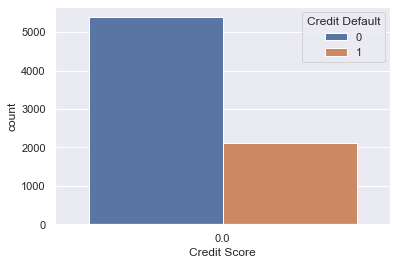

In [132]:
sns.countplot(x="Credit Score", hue='Credit Default', data=df_train)
plt.show()

### Работа с новым признаком

In [133]:
df_train['No problems'] = (df_train['Tax Liens'] == 0) & (df_train['Bankruptcies'] == 0) & (df_train['Number of Credit Problems'] == 0)
df_test['No problems'] = (df_test['Number of Credit Problems'] == 0) \
                                & (df_test['Bankruptcies'] == 0) & (df_test['Tax Liens'] == 0)

In [134]:
df_train['No problems'].value_counts()

True     6469
False    1031
Name: No problems, dtype: int64

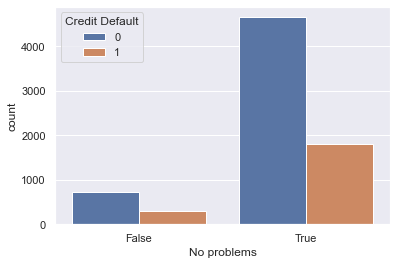

In [136]:
sns.countplot(x="No problems", hue='Credit Default', data=df_train)
plt.show()

### Целевая переменная. Credit Default

In [137]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

### Результат обработки данных

In [138]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 41 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Home Ownership                     7500 non-null   object 
 1   Annual Income                      7500 non-null   float64
 2   Years in current job               7500 non-null   float64
 3   Tax Liens                          7500 non-null   float64
 4   Number of Open Accounts            7500 non-null   float64
 5   Years of Credit History            7500 non-null   float64
 6   Maximum Open Credit                7500 non-null   float64
 7   Number of Credit Problems          7500 non-null   float64
 8   Months since last delinquent       7500 non-null   float64
 9   Bankruptcies                       7500 non-null   float64
 10  Purpose                            7500 non-null   float64
 11  Term                               7500 non-null   float

In [140]:
df_train['Purpose'] = df_train['Purpose'].astype(float)
df_test['Purpose'] = df_test['Purpose'].astype(float)

In [143]:
COL_SELECTED = [
    'Current Loan Amount BIG',
    'No problems',
    'Annual Income',
    'Years in current job',
    'Number of Open Accounts',
    'Years of Credit History',
    'Maximum Open Credit',
    'Purpose',
    'Term',
    'Current Loan Amount',
    'Current Credit Balance',
    'Monthly Debt',
    'Credit Score',
    'Home Ownership_Have Mortgage',
    'Home Ownership_Home Mortgage',
    'Home Ownership_Own Home',
    'Home Ownership_Rent',
               ]

# рабочие столбцы

In [145]:
COL_SELECTED_NUM = [
        'Annual Income',
        'Years in current job',
        'Number of Open Accounts',
        'Years of Credit History',
        'Maximum Open Credit',
        'Current Loan Amount',
        'Current Credit Balance',
        'Monthly Debt',
        'Credit Score',
                         ]

# числовые столбцы

Annual Income
MannwhitneyuResult(statistic=9348891.0, pvalue=0.4169157624974805)


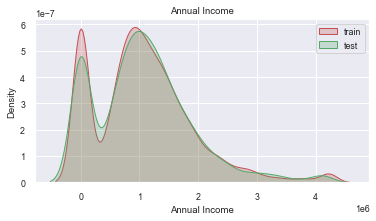

Years in current job
MannwhitneyuResult(statistic=9325493.5, pvalue=0.3434769891811027)


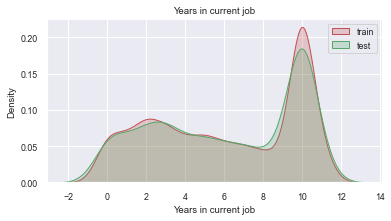

Number of Open Accounts
MannwhitneyuResult(statistic=9268381.0, pvalue=0.19604365761083925)


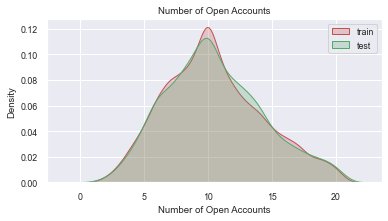

Years of Credit History
MannwhitneyuResult(statistic=9339686.0, pvalue=0.38878036831006235)


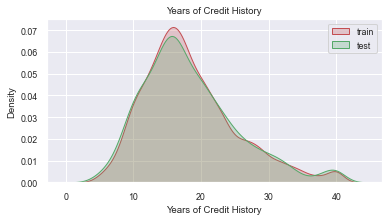

Maximum Open Credit
MannwhitneyuResult(statistic=9314533.5, pvalue=0.31429330558941404)


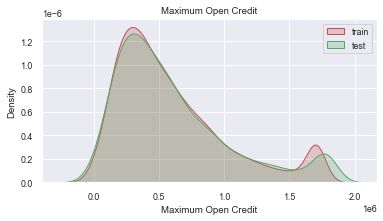

Current Loan Amount
MannwhitneyuResult(statistic=9074421.5, pvalue=0.008078991150053687)


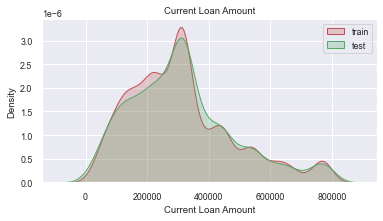

Current Credit Balance
MannwhitneyuResult(statistic=9307269.0, pvalue=0.2939671912978591)


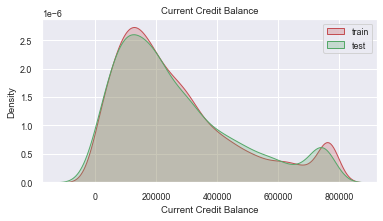

Monthly Debt
MannwhitneyuResult(statistic=9285486.0, pvalue=0.2369733356229915)


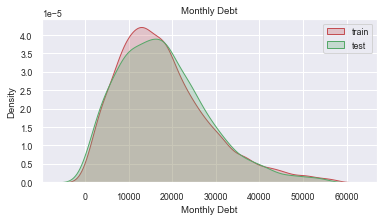

Credit Score


ValueError: All numbers are identical in mannwhitneyu

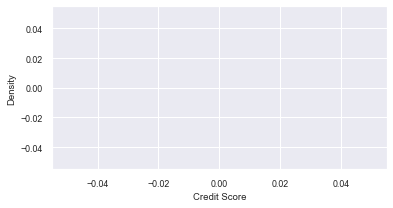

In [149]:
from scipy.stats import mannwhitneyu
figsize = (6, 3)
for col in COL_SELECTED_NUM:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(df_train[col], shade=True, label='train', color='r')
    sns.kdeplot(df_test[col], shade=True, label='test', color='g')
    print(col)
    print(mannwhitneyu(df_train[col], df_test[col]))
    plt.legend()
    plt.title(col)
    plt.show()
    
# сравнение непрерывных показателей на train и test
# p > 5% - распределения похожи

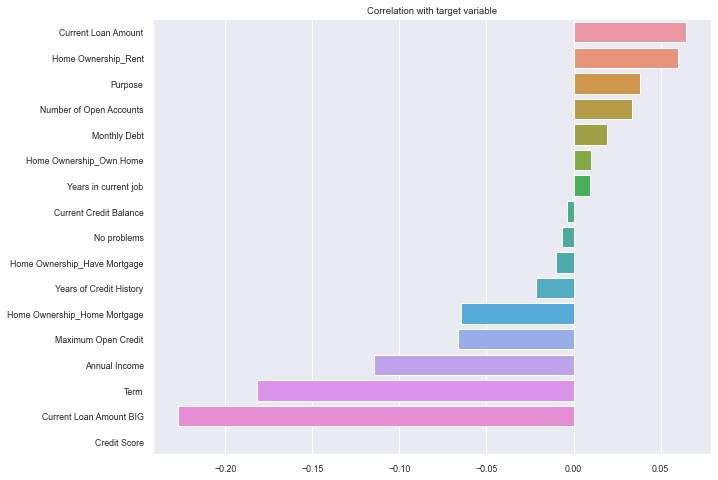

In [151]:
corr_with_target = df_train[COL_SELECTED + ['Credit Default']].corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Correlation with target variable')
plt.show()

# оченка влияния столбцов на целевой признак

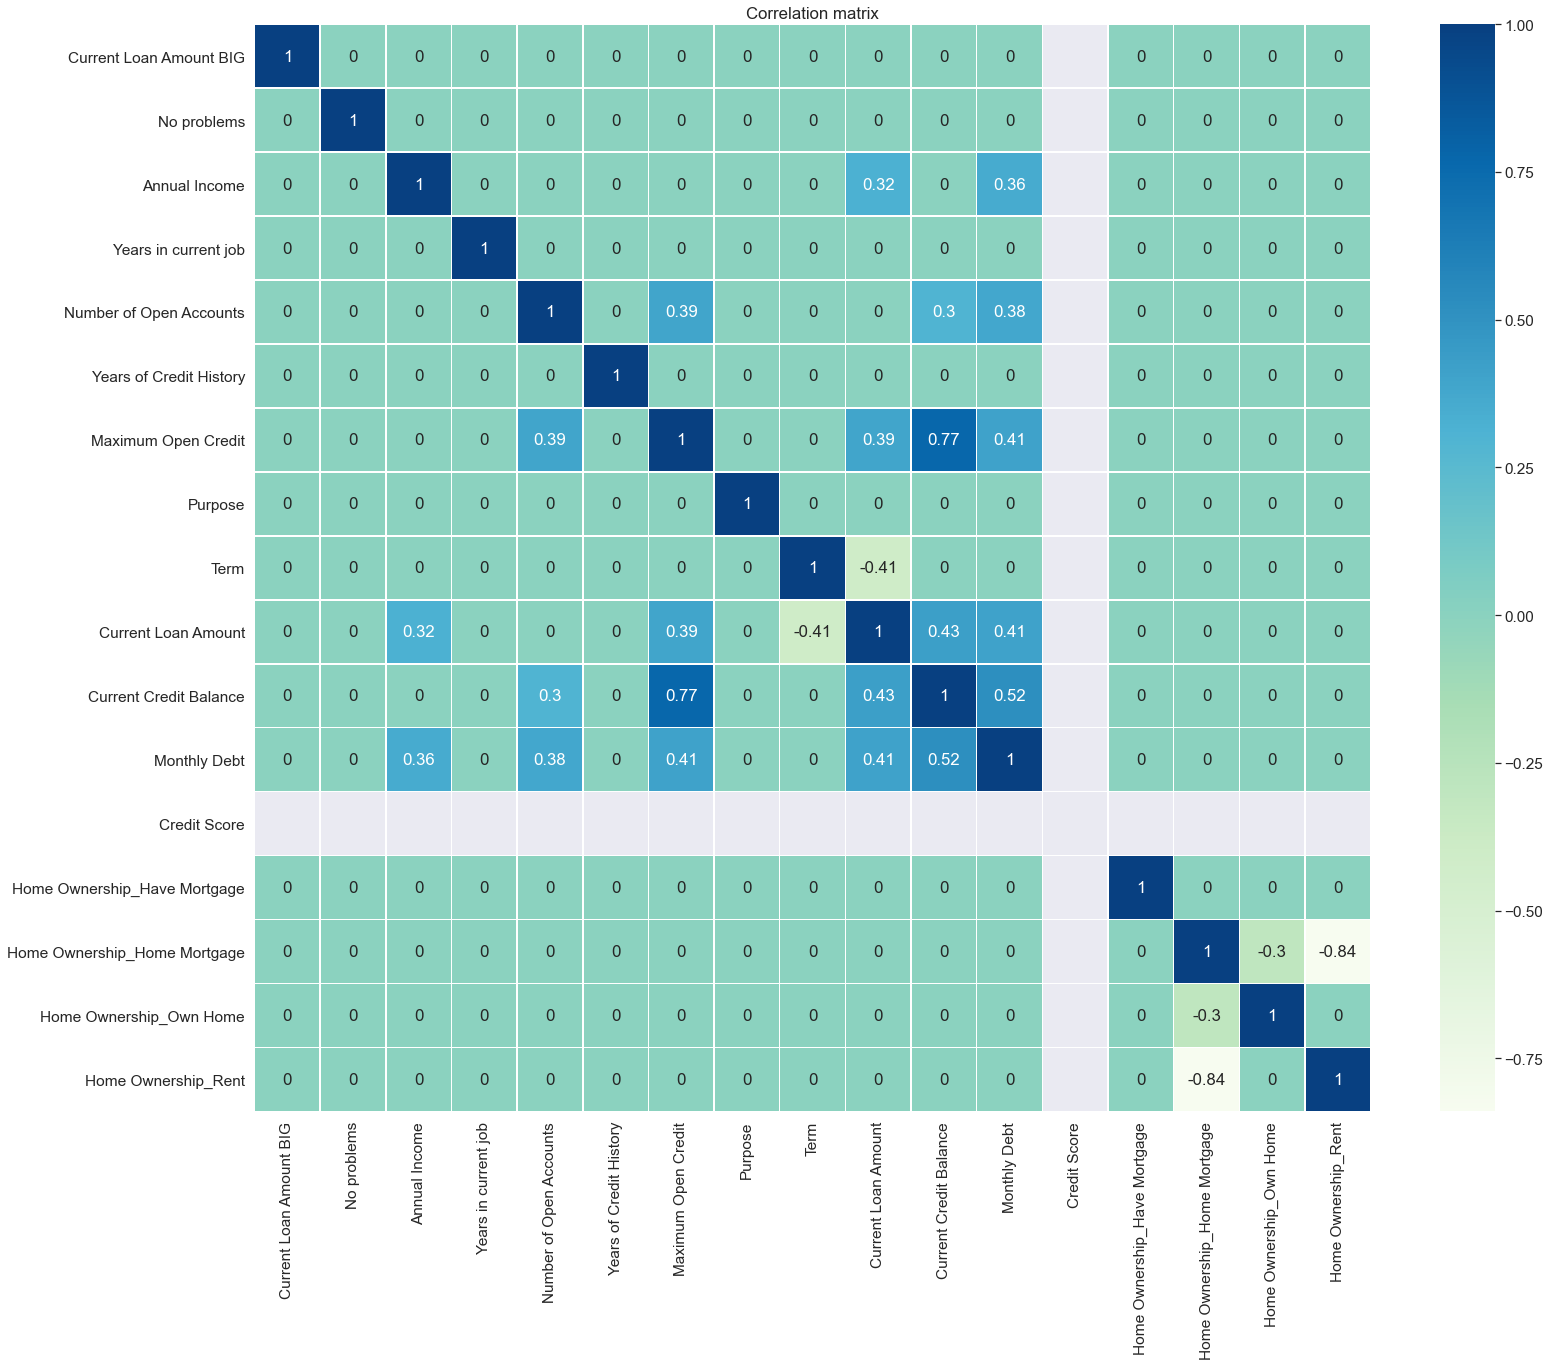

In [152]:
plt.figure(figsize = (25,20))

sns.set(font_scale=1.4)

corr_matrix = df_train[COL_SELECTED].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

# матрица корреляции

### Нормирование данных: не дало прироста результата, в связи с этим не используется

### Разбиение на trein и test 

In [153]:
X = df_train[COL_SELECTED]
y = df_train['Credit Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.30, 
                                                    random_state=21)

### Балансировка целевой переменной: не дала прироста результата, в связи с этим не используется

### Обучение на моделях

In [161]:
def pred_model(model):
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)

    print(model, '  --  ', f1_score(y_test, y_test_pred))
    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)    

### CatBoost

In [172]:
 frozen_params = {
      'class_weights':[1, 3.3], 
      'silent':True,
      'random_state':21,
      'eval_metric':'F1',
      'early_stopping_rounds':20
}

In [173]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
     y_train_pred = model.predict(X_train)
     y_test_pred = model.predict(X_test)

     get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [174]:
model = catb.CatBoostClassifier(**frozen_params,
                                 iterations=300,
                                 max_depth=7, 
                                 reg_lambda=0.5
                                 )

model.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))
evaluate_preds(model, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.96      0.20      0.33      3771
           1       0.32      0.98      0.49      1479

    accuracy                           0.42      5250
   macro avg       0.64      0.59      0.41      5250
weighted avg       0.78      0.42      0.38      5250

TEST

              precision    recall  f1-score   support

           0       0.95      0.20      0.33      1616
           1       0.32      0.97      0.49       634

    accuracy                           0.42      2250
   macro avg       0.64      0.59      0.41      2250
weighted avg       0.77      0.42      0.38      2250

CONFUSION MATRIX

col_0             0     1
Credit Default           
0               328  1288
1                18   616


In [175]:
params = {
     'reg_lambda': np.linspace(0.1, 4, 80)
}

In [176]:
model = catb.CatBoostClassifier(**frozen_params,
                                 iterations=300,
                                 max_depth=7)

In [177]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [178]:
grid_search = model.randomized_search(params, X_train, y_train, n_iter=50, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.750417426
bestIteration = 0

0:	loss: 0.7504174	best: 0.7504174 (0)	total: 89.1ms	remaining: 4.37s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.750417426
bestIteration = 0

1:	loss: 0.7504174	best: 0.7504174 (0)	total: 160ms	remaining: 3.83s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.750417426
bestIteration = 0

2:	loss: 0.7504174	best: 0.7504174 (0)	total: 220ms	remaining: 3.45s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.750417426
bestIteration = 0

3:	loss: 0.7504174	best: 0.7504174 (0)	total: 283ms	remaining: 3.25s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.750417426
bestIteration = 0

4:	loss: 0.7504174	best: 0.7504174 (0)	total: 352ms	remaining: 3.17s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.750417426
bestIteration = 0

5:	loss: 0.7504174	best: 0.7504174 (0)	total: 415ms	remaining: 3.04s
Sto

In [179]:
grid_search

{'params': {'l2_leaf_reg': 4.0},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
               48,

In [180]:
%%time
evaluate_preds(model, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.97      0.60      0.74      3771
           1       0.48      0.95      0.64      1479

    accuracy                           0.70      5250
   macro avg       0.72      0.77      0.69      5250
weighted avg       0.83      0.70      0.71      5250

TEST

              precision    recall  f1-score   support

           0       0.84      0.49      0.62      1616
           1       0.37      0.77      0.50       634

    accuracy                           0.57      2250
   macro avg       0.61      0.63      0.56      2250
weighted avg       0.71      0.57      0.58      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               784  832
1               144  490
Wall time: 26 ms


In [181]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
     train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                             cv=cv, 
                                                             scoring='f1',
                                                             train_sizes=train_sizes, 
                                                             n_jobs=n_jobs)
     train_scores_mean = np.mean(train_scores, axis=1)
     train_scores_std = np.std(train_scores, axis=1)
     test_scores_mean = np.mean(test_scores, axis=1)
     test_scores_std = np.std(test_scores, axis=1)

     plt.figure(figsize=(15,8))
     plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1, color="r")
     plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                      test_scores_mean + test_scores_std, alpha=0.1, color="g")
     plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
              label="Training score")
     plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
              label="Cross-validation score")

     plt.title(f"Learning curves ({type(estimator).__name__})")
     plt.xlabel("Training examples")
     plt.ylabel("Score")     
     plt.legend(loc="best")
     plt.grid()
     plt.show()

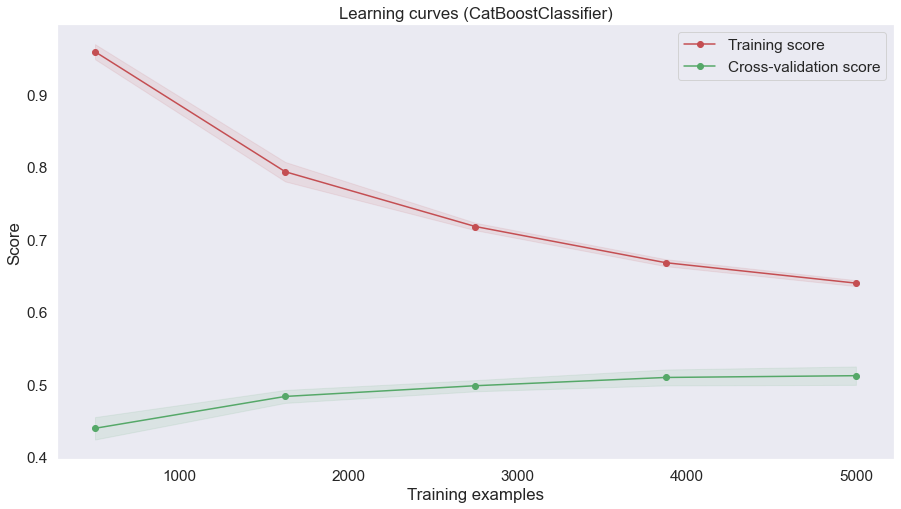

In [182]:
show_learning_curve_plot(model, X, y)

In [183]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
     feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
     feature_importances = feature_importances.sort_values('importance', ascending=False)
       
     plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
     sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
     plt.xlabel('Importance')
     plt.title('Importance of features')
     plt.show()
    
     if get_top is not None:
         return feature_importances['feature'][:get_top].tolist()

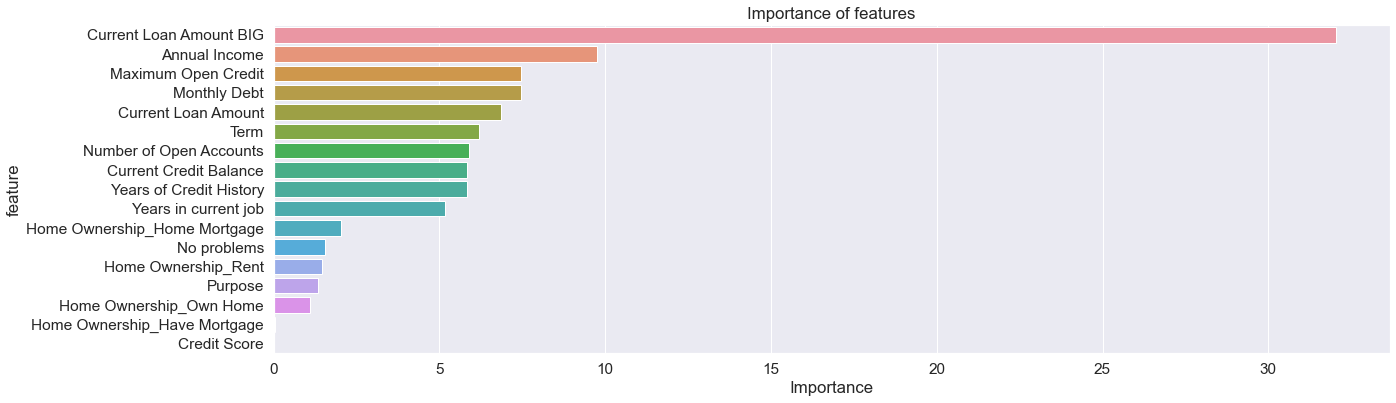

In [184]:
important_features_top = show_feature_importances(X_train.columns, model.feature_importances_, get_top=23)

In [185]:
important_features_top

['Current Loan Amount BIG',
 'Annual Income',
 'Maximum Open Credit',
 'Monthly Debt',
 'Current Loan Amount',
 'Term',
 'Number of Open Accounts',
 'Current Credit Balance',
 'Years of Credit History',
 'Years in current job',
 'Home Ownership_Home Mortgage',
 'No problems',
 'Home Ownership_Rent',
 'Purpose',
 'Home Ownership_Own Home',
 'Home Ownership_Have Mortgage',
 'Credit Score']

In [186]:
%%time
frozen_params = {
      'class_weights':[1, 3.1], 
      'silent':True,
      'random_state':21,
      'eval_metric':'F1',
      'early_stopping_rounds':20
}

final_model = catb.CatBoostClassifier(**frozen_params,
                                       iterations=300,
                                       max_depth=7,
                                       reg_lambda=0.5)

final_model.fit(X_train[important_features_top], y_train)
evaluate_preds(final_model, X_train[important_features_top], X_test[important_features_top], y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.97      0.68      0.80      3771
           1       0.53      0.95      0.68      1479

    accuracy                           0.75      5250
   macro avg       0.75      0.81      0.74      5250
weighted avg       0.85      0.75      0.77      5250

TEST

              precision    recall  f1-score   support

           0       0.83      0.55      0.66      1616
           1       0.38      0.71      0.50       634

    accuracy                           0.60      2250
   macro avg       0.60      0.63      0.58      2250
weighted avg       0.70      0.60      0.62      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               892  724
1               186  448
Wall time: 883 ms


In [203]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.3],
                                    depth=3,
                                    iterations=400, 
                                    l2_leaf_reg=300,
                                    #cat_features=CAT_FEATURE_NAMES,
                                    silent=True, 
                                    early_stopping_rounds=20, # в данном случае изменения не влияют на результат
                                    use_best_model=True,
                                    random_state=21
                                    )

frozen_params = {
      'class_weights':[1, 3.3], 
      'silent':True,
      'random_state':21,
      'eval_metric':'F1',
      'early_stopping_rounds':20
}

model_catb = catb.CatBoostClassifier(**frozen_params,
                                 iterations=400,
                                 max_depth=7, 
                                 reg_lambda=0.5
                                 )

model_catb.fit(X_train, y_train)
model_catb.fit(X_train, y_train, eval_set=(X_test, y_test))

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

print('CatBoost:: ')
print(f1_score(y_test, y_test_pred))
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

CatBoost:: 
0.4854215918045705
TRAIN

              precision    recall  f1-score   support

           0       0.96      0.20      0.33      3771
           1       0.32      0.98      0.49      1479

    accuracy                           0.42      5250
   macro avg       0.64      0.59      0.41      5250
weighted avg       0.78      0.42      0.38      5250

TEST

              precision    recall  f1-score   support

           0       0.95      0.20      0.33      1616
           1       0.32      0.97      0.49       634

    accuracy                           0.42      2250
   macro avg       0.64      0.59      0.41      2250
weighted avg       0.77      0.42      0.38      2250

CONFUSION MATRIX

col_0             0     1
Credit Default           
0               328  1288
1                18   616


### Другие модели

In [204]:
for model in [
# Логистическая регрессия
            LogisticRegression(C = 0.1, class_weight = 'balanced', penalty = 'l1', solver = 'liblinear', max_iter = 50),     
            xgb.XGBClassifier(eval_metric="logloss", max_depth=50, reg_lambda=1, random_state=21),
            KNeighborsClassifier(),      # К-ближайших соседей
            BaggingClassifier(),         # Беггинг
            RandomForestClassifier(),    # Случайный лес    
# Дерево решений
            DecisionTreeClassifier(random_state=21, class_weight={0:1, 1:3.3}, max_depth=4),
            lgbm.LGBMClassifier(class_weight={0:1, 1:3.3}, random_state=21),
            catb.CatBoostClassifier(class_weights=[1, 3.3], silent=True),
            AdaBoostClassifier(),    
            SVC(C=0.05, kernel='rbf'),   # Метод опорных векторов
            GaussianNB(),
            ExtraTreesClassifier(random_state=42, bootstrap=True, min_samples_split=0.3, class_weight='balanced'),
            GradientBoostingClassifier(learning_rate=7, random_state=42), # Бустинг
            Perceptron(class_weight='balanced')    
]:
        pred_model(model)

LogisticRegression(C=0.1, class_weight='balanced', max_iter=50, penalty='l1',
                   solver='liblinear')   --   0.49665924276169265
TRAIN

              precision    recall  f1-score   support

           0       0.96      0.20      0.33      3771
           1       0.32      0.98      0.49      1479

    accuracy                           0.42      5250
   macro avg       0.64      0.59      0.41      5250
weighted avg       0.78      0.42      0.38      5250

TEST

              precision    recall  f1-score   support

           0       0.83      0.56      0.67      1616
           1       0.38      0.70      0.50       634

    accuracy                           0.60      2250
   macro avg       0.61      0.63      0.58      2250
weighted avg       0.70      0.60      0.62      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               900  716
1               188  446
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
  

### Ансамбль на лучших моделях

In [205]:
model_vote = VotingClassifier(
    estimators=[
#         ('Logistic Regression', 
#                  LogisticRegression(C = 5, class_weight = 'balanced', penalty = 'l1', solver = 'liblinear', max_iter = 50)),
#         ('XGBoost', xgb.XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=21)),
#         ('K-Neighbours', KNeighborsClassifier()),
#         ('DecisionTree', DecisionTreeClassifier(random_state=21,
#                                     class_weight={0:1, 1:3.6},
#                                     max_depth=4
#                                     )),
        ('LightGBM', lgbm.LGBMClassifier(class_weight={0:1, 1:3.3}, random_state=21)),
        ('CatBooster', 
                            catb.CatBoostClassifier(class_weights=[1, 3.3], 
                                    depth=3,
                                    iterations=400,
#                                     l2_leaf_reg=300,
#                                     cat_features=CAT_FEATURE_NAMES,
                                    silent=True, 
#                                     early_stopping_rounds=20, #  изменения тут на результат не влияют
#                                     use_best_model=True,
#                                     random_state=21
                                    )),
#         ('Ada Boost', AdaBoostClassifier()),
#         ('SVM', SVC()),
#         ('Naive Bayes', GaussianNB()),
        ('Extra Tree', 
                ExtraTreesClassifier(random_state=42, bootstrap=True, min_samples_split=0.3, class_weight='balanced')),
#         ('Gradient Boosting', GradientBoostingClassifier(learning_rate=7, random_state=42)),
#         ('Perceptron', Perceptron(class_weight='balanced'))
    ],
#     voting='hard',
    voting='soft', # в этом случае вероятности суммируются и в итоге берется чито-то вроде среднего
    weights=[1,1.5,1],
    n_jobs=-1)

model_vote.fit(X_train, y_train)

y_train_pred = model_vote.predict(X_train)
y_test_pred = model_vote.predict(X_test)

print('VOTE:: ')
print(f1_score(y_test, y_test_pred))
# get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

VOTE:: 
0.5021413276231264


### Итог и сохранение данных

In [206]:
df_test["Credit Default"] = model_vote.predict(df_test[COL_SELECTED])
df_test["Credit Default"] = model_catb.predict(df_test[COL_SELECTED])

df_test['ID'] = df_test.index.tolist()
df_test['ID'] = df_test['ID']
df_test1 = df_test[['Credit Default', 'ID']]

df_test1.to_csv(r'__Vote_01_9_.csv', index=False)
df_test1.to_csv(r'___Cat_best_.csv', index=False)